In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import math 
import sys
sys.path.append("../class")
from Flow_class import Flow
from Transport_class import Transport
from Reaction_class import Reaction

In [2]:
Nx=100
Ny=5

In [3]:
#gb= pp.grid_buckets_2d.single_vertical([Nx, Ny], y_endpoints=[0.6, 0.2], simplex=False)
#gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)
#print(domain)
#pp.plot_grid(gb,figsize=[15,12])
#domain={'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}




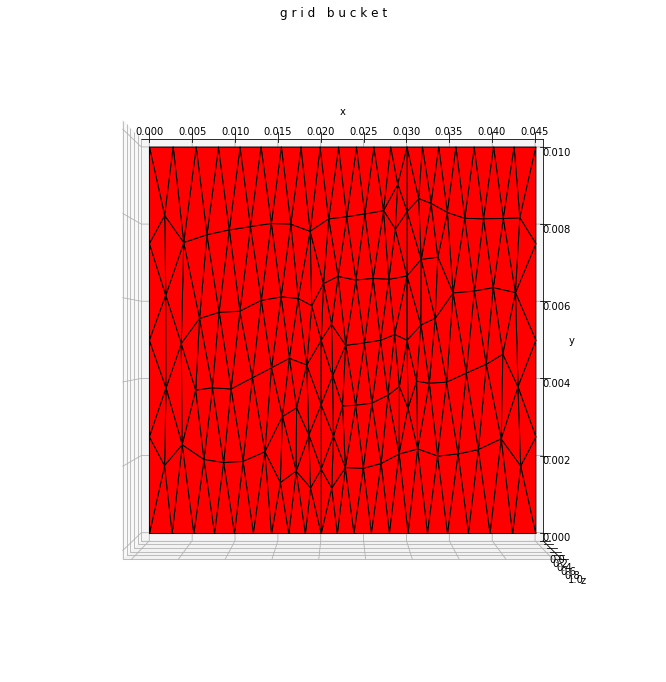

In [4]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb = network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [5]:
parameter={"aperture":1e-3,
           "fracture_perm":0.00001,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
          #"fracture_perm":0.001,
           "perm":0.3,
           #"perm":1,
          
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[5.0e-9,0.0],
           #"bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

matrix permeability
[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.

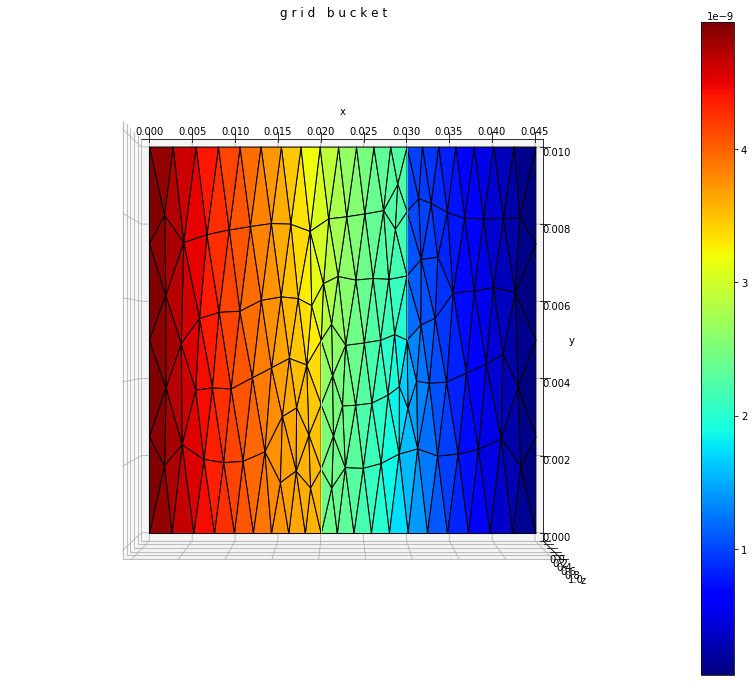

In [6]:
flow=Flow(gb,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [7]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    "por_frac":0.00001,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)

In [8]:
Ca_value=[0.0,0.0]
Ca_type=['dir','dir']
CaSiO3_value=[0.0,0.0]
CaSiO3_type=['dir','dir']
Ca="Ca"
CaSiO3="CaSiO3"

In [9]:
reaction_data={"temperature":423,
       "A":1.9e-2,
       #"rate_const":0.00446,
       "rate_const":0.0005,
       "E":4700,
       "R":8.314,
       "K_eq":10e9,
       "ph":3.5,
       "mass_weight":0.3*1.0}
reaction=Reaction(reaction_data)
reaction.set_const_rate()
print(reaction.const_rate)

2.4964205820053154e-06


In [10]:
transport.set_data(Ca_value,Ca_type,Ca)
transport.get_flux(Ca)
transport.discretize(Ca)
lhs_Ca,rhs_source_adv_Ca,rhs_mass_Ca,assembler_Ca=transport.get_transport_lhs_rhs(Ca)
#ciao?1



In [11]:
for g,d in gb:
    print(d[pp.PARAMETERS]["Ca"]["darcy_flux"])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.66404907e-12
  8.30958398e-12  0.00000000e+00  5.32513224e-11 -4.30632526e-11
 -1.12875506e-10  9.18694853e-11  7.71197383e-11  0.00000000e+00
 -1.15408628e-10 -5.39004135e-11  6.09646763e-11  9.30806259e-11
 -9.83453533e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.82301235e-12  7.29794982e-12  0.00000000e+00 -6.58663609e-11
 -4.47563998e-11  0.00000000e+00  6.79834385e-11  4.63856278e-11
  6.50763682e-11  0.00000000e+00  4.44925483e-11  0.00000000e+00
 -6.84106103e-11 -4.70055600e-11  0.00000000e+00  2.25760591e-11
 -8.30958398e-12  0.00000000e+00  2.46662737e-11 -2.25760591e-11
  0.00000000e+00 -2.46662737e-11  4.60802076e-11  0.00000000e+00
 -4.68844560e-11  4.60802076e-11  0.00000000e+00 -4.68844560e-11
 -4.77007022e-11  0.00000000e+00  4.95873905e-11  4.77007022e-11
  0.00000000e+00 -4.95873905e-11  5.89614591e-11 -5.89614591e-11
  4.47563998e-11  0.00000000e+00 -2.88065644e-11  9.66404907e-12
  0.00000000e+00  4.33875

In [12]:
print(rhs_source_adv_Ca)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


P0_flux
[[ 2.38594227e-08  2.47624400e-08  2.22062685e-08  1.99010967e-08
   2.46516131e-08  2.45250724e-08  1.87753514e-08  3.45494627e-08
   2.31657684e-08  2.79616968e-08  4.19287314e-08  3.03122355e-08
   3.35835290e-08  7.97741067e-12  2.76555159e-08  2.70926365e-08
   7.54352881e-12  8.00386683e-12  9.97802818e-09  3.50570238e-08
   1.41580999e-08  3.32206672e-08  2.65862065e-08  3.78599410e-08
   2.88709077e-08  1.13456598e-11  2.67600411e-08  4.30148238e-08
   2.64509401e-08  3.65201181e-08  2.08396442e-08  2.58918320e-08
   2.90950554e-08  4.08342385e-08  1.69099503e-08  1.60909838e-08
   1.52292436e-08  2.25520644e-08  3.40046052e-08  1.51160195e-08
   2.57846479e-08  2.90974585e-08  2.64741359e-08  2.79357341e-08
   2.56116574e-08  1.88634005e-08  3.12010297e-08  2.59669538e-08
   2.65875475e-08  3.80723241e-08  2.06771281e-08  3.30254812e-08
   2.48726675e-08  4.31635101e-08  2.64486351e-08  3.47140336e-08
   3.77816653e-08  4.37023293e-08  2.47852338e-08  3.73169880e-08
  

/home/dell/anaconda3/lib/python3.8/site-packages/porepy/viz/plot_grid.py:127: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


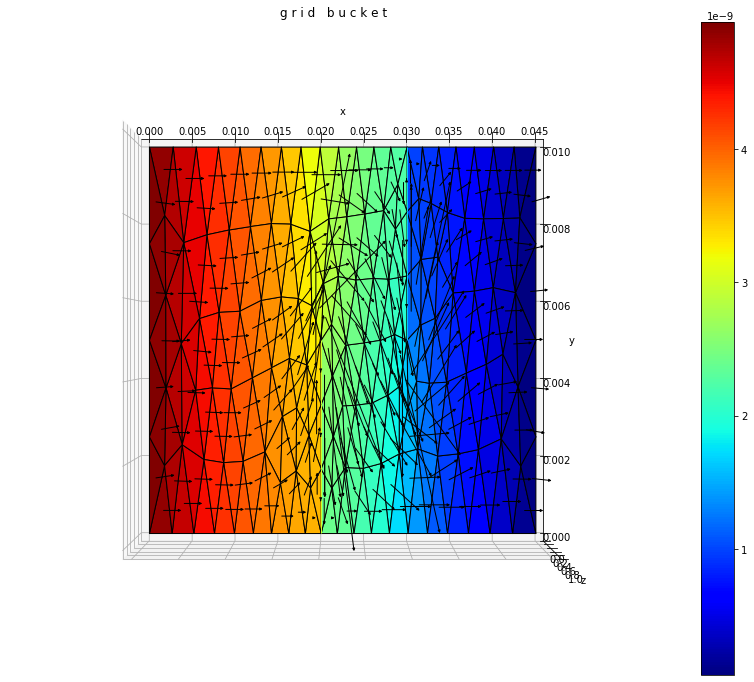

In [13]:
## to export the flux
key='Ca'
flux='darcy_flux'
mortar='mortar_flux'
flux_P0="P0_flux"

discr_P0_flux = pp.MVEM(key)
for g, d in gb:
    discr_P0_flux.discretize(g, d)
    d[pp.STATE][flux] = d[pp.PARAMETERS][key][flux]

## construct the P0 flux reconstruction
pp.project_flux(gb, discr_P0_flux, flux, flux_P0, mortar)

for g,d in gb:
    print("P0_flux")
    print(d[pp.STATE]["P0_flux"])

for g,d in gb:
    print("pressure")
    print(d[pp.STATE]["pressure"])
    
for g,d in gb:
    d[pp.STATE]["P0_flux"]*=100000
pp.plot_grid(gb,"pressure","P0_flux",figsize=(15,12))

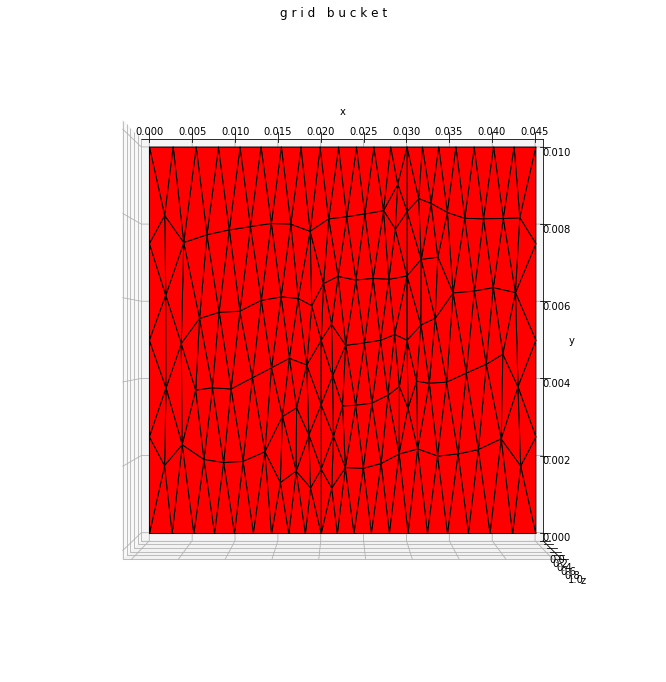

In [14]:
# Point coordinates, as a 2xn array
p = np.array([[0.02,0.02,0.03,0.03], [0,0.005,0.005,0.01]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': 0, 'xmax': 0.045, 'ymin': 0, 'ymax': 0.01}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
#mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}
mesh_args = {'mesh_size_frac': 0.002, 'mesh_size_bound': 0.003}


# Generate a mixed-dimensional mesh
gb1= network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [15]:
parameter={"aperture":1e-3,
           "fracture_perm":0.00001,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
           #"fracture_perm":1.0,
           "perm":0.3,
           #"perm":1.0,
           #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          #"bc_value":[3.0e-7,0.0],
          "bc_value":[0.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

matrix permeability
[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.

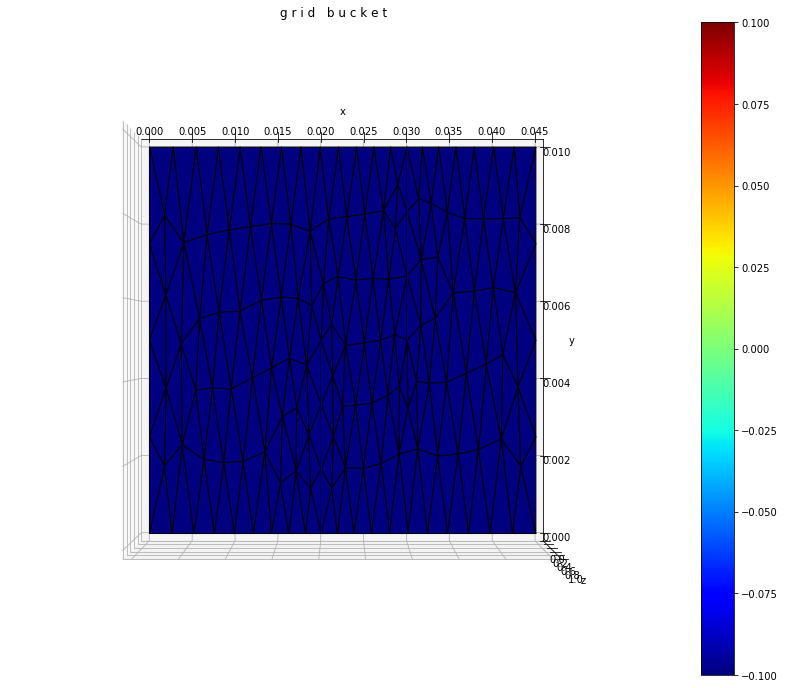

In [16]:
flow=Flow(gb1,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

In [17]:
parameter={
    "aperture":1e-3,
    "por":0.3,
    "por_frac":0.00001,
    #"por":1.0,
    #"por_frac":1.0,
    #"time_step":1 / 60,
    "time_step":34.56,
    #"time_step":0.001,
    #"t_max":1 /3,
    "t_max":345600,
    #"t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport_CaSiO3=Transport(gb1,domain,parameter)

In [18]:
transport_CaSiO3.set_data(CaSiO3_value,CaSiO3_type,CaSiO3)
transport_CaSiO3.get_flux(CaSiO3)    
transport_CaSiO3.discretize(CaSiO3)
lhs_CaSiO3,rhs_source_adv_CaSiO3,rhs_mass_CaSiO3,assembler_CaSiO3=transport_CaSiO3.get_transport_lhs_rhs(CaSiO3)

In [19]:
save_every = 100
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer1 = np.zeros(rhs_source_adv_Ca.size)
assembler_Ca.distribute_variable(
    tracer1, variable_names=[Ca,transport.mortar_variable]
)

tracer2 = 16.7504*np.ones(rhs_source_adv_CaSiO3.size)
assembler_CaSiO3.distribute_variable(
    tracer2, variable_names=[CaSiO3,transport.mortar_variable]
)


# Exporter
exporter1 = pp.Exporter(gb, file_name="Ca", folder_name="Ca")
export_field1 = ["Ca"]
IEsolver_Ca = sps.linalg.factorized(lhs_Ca)

exporter2= pp.Exporter(gb1, file_name="CaSiO3", folder_name="CaSiO3")
export_field2 = ["CaSiO3"]
IEsolver_CaSiO3 = sps.linalg.factorized(lhs_CaSiO3)

/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Ca
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Ca
[0. 0. 0.]
Ca
[0. 0. 0.]
CaSiO3
[16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504
 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504
 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 16.7504 1

Ca
[0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713109
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713109 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713108 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713097 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70705039 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70713111 0.70709993 0.70713111 0.70713111 0.70713111 0.70713111
 0.69361744 0.70713059 0.70713111 0.70712074 0.70713111 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70349294 0.70713111
 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111 0.70713111
 0.70691668 0.70712981 0.70713111 0.70713111 0.70579665 0.7

Ca
[1.38376826 1.38376894 1.38376911 1.38376911 1.38376445 1.38374238
 1.38376905 1.3837691  1.38376911 1.38376911 1.3837691  1.38376911
 1.38376911 1.38376911 1.38376911 1.38375049 1.38376911 1.38376911
 1.38376911 1.38376911 1.38376911 1.38376911 1.38376911 1.38376911
 1.38376911 1.38376911 1.38373281 1.38376911 1.38376911 1.38376909
 1.38376911 1.38367823 1.38376911 1.38376911 1.38376911 1.3837691
 1.38376911 1.38376911 1.38376911 1.38376911 1.38376911 1.38376911
 1.38376225 1.38376911 1.38376911 1.3837691  1.38376911 1.38376911
 1.38376911 1.3837691  1.38376911 1.38376908 1.38376911 1.38376911
 1.37692807 1.38376911 1.38376911 1.38376911 1.38376911 1.38376911
 1.38376911 1.38064953 1.38376911 1.38376902 1.38376911 1.38376911
 1.21520068 1.38357821 1.38376911 1.38204854 1.3837691  1.38376911
 1.3837687  1.3837691  1.38376911 1.38376911 1.3036832  1.38376911
 1.38376911 1.38376896 1.38376911 1.38376911 1.38376911 1.38376911
 1.37255901 1.38335104 1.38376911 1.38376911 1.34710493 1.38

Ca
[2.03063897 2.03069197 2.03071317 2.03071317 2.03043502 2.02964283
 2.03070538 2.03071158 2.03071317 2.03071317 2.03071272 2.03071317
 2.03071317 2.03071317 2.03071317 2.02993397 2.03071317 2.03071317
 2.03071317 2.03071317 2.03071316 2.03071317 2.03071317 2.03071317
 2.03071317 2.03071317 2.02930967 2.03071298 2.03071317 2.03070996
 2.03071317 2.02812608 2.03071317 2.03071317 2.03071317 2.03071276
 2.03071317 2.03071317 2.03071314 2.03071317 2.03071317 2.03071317
 2.03031955 2.03071317 2.03071317 2.03071148 2.03071316 2.03071317
 2.03071317 2.03071284 2.03071317 2.03070799 2.03071317 2.03071317
 1.96868157 2.03071317 2.03071316 2.03071317 2.03071317 2.03071308
 2.03071317 1.99804679 2.03071317 2.0307014  2.03071317 2.03071317
 1.48188049 2.02654193 2.03071317 2.007879   2.03071066 2.03071317
 2.03067462 2.03071217 2.03071317 2.03071317 1.68702593 2.03071317
 2.03071317 2.03069378 2.03071317 2.03071317 2.03071314 2.03071317
 1.94883079 2.02261787 2.03071317 2.03071317 1.84230038 2.0

Ca
[2.64755862 2.64838033 2.64886383 2.64886383 2.6451343  2.63801625
 2.64866162 2.6488034  2.64886383 2.64886383 2.64884232 2.6488637
 2.64886383 2.64886383 2.64886363 2.64063007 2.64886367 2.64886383
 2.64886383 2.64886383 2.64886337 2.64886353 2.64886382 2.64886383
 2.64886375 2.64886383 2.6351101  2.64885287 2.64886383 2.64876308
 2.64886383 2.6278966  2.64886383 2.64886383 2.64886383 2.64884579
 2.64886383 2.64886382 2.64886166 2.64886383 2.64886383 2.64886383
 2.64378757 2.64886383 2.64886383 2.64880605 2.64886317 2.64886383
 2.64886383 2.64884744 2.64886383 2.64870998 2.64886382 2.64886383
 2.41677643 2.64886383 2.64886296 2.64886383 2.64886383 2.64885784
 2.64886383 2.51068425 2.64886383 2.64857693 2.64886383 2.64886383
 1.56489257 2.61995214 2.64886383 2.53862533 2.64877188 2.64886382
 2.64813009 2.64882381 2.64886383 2.64886383 1.85537895 2.64886383
 2.64886383 2.64841821 2.64886383 2.6488638  2.64886143 2.64886383
 2.37560465 2.59845067 2.64886346 2.64886339 2.147614   2.64

Ca
[3.22961891 3.23488915 3.23919507 3.23919506 3.21688755 3.18667105
 3.2371735  3.23840512 3.23919507 3.23919507 3.23885825 3.23918987
 3.23919507 3.23919507 3.23918814 3.19775456 3.23919006 3.23919507
 3.23919506 3.23919507 3.23918328 3.23918453 3.2391948  3.23919507
 3.23919161 3.23919507 3.17468177 3.23899738 3.23919507 3.23803941
 3.23919507 3.15251005 3.23919507 3.23919507 3.23919498 3.23892283
 3.23919507 3.23919477 3.23914423 3.23919507 3.239195   3.23919506
 3.20994287 3.23919507 3.23919507 3.23848135 3.23917604 3.23919507
 3.23919507 3.23892882 3.23919507 3.23751567 3.23919433 3.23919507
 2.69032397 3.23919507 3.23917004 3.23919507 3.23919507 3.23907799
 3.23919507 2.8771447  3.23919507 3.23647471 3.23919507 3.23919507
 1.55607578 3.13102035 3.23919507 2.9266021  3.23803927 3.23919449
 3.23340066 3.23864738 3.23919504 3.23919507 1.88653176 3.23919507
 3.23919506 3.23519237 3.23919507 3.23919383 3.23913721 3.23919507
 2.63312167 3.06743814 3.23918292 3.23918064 2.28732124 3.2

Ca
[3.76191564 3.78138889 3.80273063 3.80273051 3.72171068 3.64108329
 3.79162372 3.79743006 3.80273063 3.80273063 3.80012255 3.8026477
 3.80273063 3.80273057 3.80262938 3.67061905 3.8026638  3.80273062
 3.80273047 3.80273063 3.80259389 3.80257964 3.80272389 3.80273063
 3.80267224 3.80273063 3.60994986 3.80102993 3.80273063 3.7956727
 3.80273063 3.56516975 3.80273063 3.80273062 3.80272807 3.80065387
 3.80273063 3.80272363 3.80218942 3.80273063 3.80272846 3.80273051
 3.70015729 3.80273063 3.80273063 3.79808574 3.80249336 3.80273063
 3.80273063 3.80060374 3.80273063 3.79292831 3.80271481 3.80273062
 2.81000211 3.80273063 3.80242079 3.80273061 3.80273063 3.80165104
 3.8027306  3.09078448 3.80273063 3.7884355  3.80273063 3.80273062
 1.51073667 3.52525575 3.80273063 3.15731566 3.79528136 3.80271859
 3.77630005 3.79889681 3.80272981 3.80273063 1.85095918 3.80273059
 3.80273046 3.78271549 3.80273063 3.80270613 3.80210746 3.80273056
 2.74622286 3.39632278 3.80256755 3.80253672 2.31488288 3.802

Ca
[4.21975294 4.26929893 4.34052418 4.34052182 4.12959356 3.97178768
 4.29989792 4.31791653 4.34052418 4.34052414 4.32802504 4.33981981
 4.34052415 4.34052297 4.3397102  4.02951294 4.34001904 4.34052391
 4.34052132 4.3405241  4.33960115 4.339342   4.34044087 4.34052416
 4.33999997 4.34052415 3.91238141 4.33168294 4.34052418 4.31244335
 4.34052418 3.84366925 4.34052418 4.34052403 4.34048898 4.33058538
 4.34052407 4.34044042 4.33716775 4.34052414 4.34049319 4.34052182
 4.08204268 4.34052418 4.34052418 4.32099698 4.3388497  4.34052418
 4.34052418 4.33005129 4.34052416 4.30310574 4.34035241 4.3405239
 2.82171864 4.34052417 4.33836874 4.34052366 4.34052418 4.33455934
 4.34052339 3.17613388 4.34052418 4.29017684 4.34052418 4.34052385
 1.45374901 3.78555865 4.34052417 3.25214956 4.30999344 4.34039444
 4.2573375  4.323523   4.34051079 4.34052412 1.78906817 4.34052325
 4.34052123 4.27314367 4.34052418 4.34027339 4.33665309 4.34052257
 2.75841565 3.58137624 4.33932268 4.33909554 2.27876245 4.34

Ca
[4.57741336 4.67411205 4.85364291 4.85361687 4.41860641 4.16973929
 4.74257844 4.7839488  4.85364291 4.85364219 4.81121322 4.84984224
 4.85364227 4.85362822 4.8493982  4.26063928 4.85111207 4.8536386
 4.85361298 4.85364144 4.84942809 4.84766121 4.85302945 4.85364245
 4.85066395 4.85364231 4.07820496 4.82163804 4.85364291 4.77147101
 4.85364289 3.99052194 4.85364291 4.85364047 4.8533555  4.81965801
 4.85364093 4.85303489 4.83954538 4.85364204 4.85338478 4.85361747
 4.33610475 4.85364291 4.85364291 4.79368067 4.84581108 4.85364289
 4.85364291 4.81722714 4.85364257 4.74819666 4.85250728 4.85363832
 2.76968024 4.85364274 4.84374711 4.85363495 4.85364291 4.83085325
 4.85363266 3.17031923 4.85364285 4.72037634 4.85364284 4.85363806
 1.39459114 3.91852658 4.85364271 3.24935138 4.76305304 4.85277499
 4.65255354 4.79932429 4.8535176  4.85364184 1.71923235 4.85363158
 4.85361308 4.68240664 4.85364291 4.8520529  4.83745993 4.85362179
 2.71004738 3.64513753 4.84788211 4.84680231 2.21136871 4.85

Ca
[4.81939088 4.97481046 5.34315408 5.34296818 4.58457181 4.24806412
 5.09841177 5.17430899 5.34315418 5.34314541 5.23176103 5.32854547
 5.34314624 5.34304059 5.32717033 4.37079441 5.33384233 5.34311201
 5.34294939 5.34313771 5.32879668 5.32133571 5.3400908  5.34314857
 5.33115049 5.34314681 4.12682934 5.25468673 5.3431542  5.15174863
 5.34315378 4.02787032 5.34315412 5.34313012 5.34157126 5.2527758
 5.3431328  5.34012687 5.29893001 5.34314372 5.34172152 5.34297709
 4.4642385  5.3431542  5.34315423 5.19744204 5.31625497 5.34315385
 5.34315422 5.24547139 5.34314963 5.10576685 5.33797609 5.34310829
 2.68524819 5.34315186 5.30986734 5.34308061 5.34315422 5.27706545
 5.34307064 3.10793044 5.34315329 5.05749168 5.3431531  5.34311064
 1.33647291 3.94765702 5.34315136 3.18605939 5.13138123 5.33910317
 4.94277421 5.20719259 5.34238618 5.34314246 1.64864601 5.34306678
 5.34295638 4.98919668 5.34315422 5.33612467 5.29282676 5.34298277
 2.6298953  3.62148899 5.32308186 5.31938972 2.13097096 5.34

Ca
[4.94616976 5.16236595 5.81011325 5.80916924 4.64078066 4.23327686
 5.35207175 5.46950762 5.81011431 5.81004457 5.56976595 5.76684462
 5.81005042 5.80949705 5.7633212  4.38169417 5.7831156  5.80983759
 5.80910756 5.80999297 5.77109045 5.74826254 5.79878097 5.81006996
 5.77302826 5.81005548 4.08905693 5.61110881 5.81011456 5.43528142
 5.81011016 3.98583505 5.81011365 5.80995417 5.80369674 5.6119083
 5.80996145 5.79886729 5.69926754 5.81003243 5.80430657 5.80923709
 4.48616544 5.81011457 5.81011505 5.51393087 5.73730376 5.81011083
 5.81011488 5.59525239 5.81007517 5.35921842 5.79238229 5.80980817
 2.58703605 5.81009424 5.72195362 5.80965484 5.8101148  5.65499344
 5.80964231 3.01460102 5.81010587 5.28797893 5.81010379 5.80984696
 1.28035732 3.90230797 5.81008923 3.09003564 5.39659786 5.79582168
 5.1210335  5.52762033 5.80672358 5.81002925 1.57980996 5.80964126
 5.80916975 5.18354193 5.8101149  5.78660613 5.68535282 5.80915579
 2.53549143 3.54270237 5.75529934 5.7455126  2.04675394 5.80

Ca
[4.97234962 5.24230404 6.25554844 6.25189532 4.6108739  4.15465017
 5.49951103 5.65901122 6.25555668 6.25516258 5.81019298 6.15106403
 6.25519245 6.25302418 6.14323611 4.32060417 6.1906649  6.25423437
 6.25175407 6.25491554 6.16673143 6.11168916 6.2224569  6.25530644
 6.16261651 6.25522252 3.99555388 5.8741051  6.25555875 5.61357674
 6.25552665 3.89284313 6.25555183 6.25477826 6.23516278 5.88159039
 6.25477008 6.22243186 6.02249436 6.25510059 6.23718761 6.2522385
 4.42975339 6.25555898 6.25556332 5.73139978 6.09211803 6.25553108
 6.25556155 5.85055381 6.25532    5.50390852 6.20707813 6.25407572
 2.48481406 6.25543393 6.06190619 6.25345535 6.25556081 5.94687469
 6.25356357 2.9067607  6.2555009  5.41091892 6.25548551 6.25434364
 1.22646896 3.80933692 6.25540037 2.97895029 5.55207113 6.21517894
 5.19417896 5.7475339  6.24401092 6.25511101 1.51347858 6.25362441
 6.25207983 5.26983989 6.25556183 6.19250176 5.99640989 6.25156927
 2.43640162 3.43333745 6.13170465 6.11047736 1.96294595 6.23

Ca
[4.92028895 5.23135897 6.68042112 6.66908237 4.52070232 4.0372142
 5.54850943 5.74459677 6.68046809 6.67878147 5.94803738 6.46590311
 6.67889904 6.67219671 6.45044085 4.21289795 6.54621232 6.67558024
 6.66886982 6.67788292 6.50495493 6.39453926 6.60047138 6.67939609
 6.48343019 6.67903021 3.87057174 6.03564102 6.68048028 5.69007693
 6.68030819 3.77092384 6.68044191 6.67753721 6.62724178 6.05391333
 6.67736747 6.59956244 6.25417101 6.67854219 6.6328648  6.67037194
 4.32220214 6.68048254 6.68051088 5.84836315 6.36441387 6.6803298
 6.68049799 6.00434715 6.67939423 5.54797064 6.56973912 6.67494688
 2.3832421  6.67990416 6.31372115 6.67300089 6.68049334 6.14131285
 6.67381984 2.79388811 6.68019403 5.43730886 6.68011085 6.67616247
 1.1748058  3.68931611 6.67973967 2.86283483 5.60456052 6.58512384
 5.17925736 5.86462802 6.64857258 6.67867746 1.44981049 6.67418366
 6.67009754 5.26398042 6.68050032 6.53875704 6.21231023 6.66740955
 2.33741098 3.30955073 6.439462   6.40023316 1.88133826 6.633

Ca
[4.8135212  5.15147348 7.08551789 7.05617357 4.3927993  3.89921192
 5.51529765 5.73886845 7.08572386 7.07998679 5.98940512 6.69886731
 7.08036131 7.06333514 6.67133619 4.07841001 6.83966611 7.07109324
 7.05605739 7.0773827  6.77630873 6.58481985 6.91987017 7.08206878
 6.72074777 7.08080472 3.73058653 6.09872596 7.08577894 5.67817522
 7.08506423 3.63501736 7.08561545 7.07678617 6.96748457 6.13066571
 7.07591069 6.91609462 6.38816514 7.07925313 6.98080234 7.06002085
 4.18522835 7.08579337 7.08593498 5.87337685 6.54356931 7.08514551
 7.08586449 6.06048914 7.08188135 5.50864626 6.8669748  7.06910804
 2.28435213 7.08368077 6.46875621 7.06415529 7.08584191 6.2368646
 7.06745463 2.68100682 7.08467156 5.38569092 7.0843245  7.07324011
 1.1253012  3.55618033 7.08305551 2.74689052 5.57082322 6.89125006
 5.09779598 5.88745277 7.01142713 7.07994769 1.38877543 7.06877549
 7.0596929  5.18754795 7.08587828 6.80976852 6.32882271 7.05057396
 2.24072776 3.18088825 6.66933809 6.60561619 1.80260893 6.98

Ca
[4.67240106 5.024374   7.47120356 7.40594968 4.24413166 3.75248352
 5.41972343 5.66077646 7.47192781 7.45582348 5.94886724 6.8439786
 7.45682459 7.42011062 6.79935181 3.93085826 7.06346109 7.43518397
 7.4063989  7.44958218 6.97484122 6.67937014 7.16856703 7.46163749
 6.8661328  7.45803614 3.58558633 6.07572917 7.47212771 5.59676882
 7.46973175 3.4942823  7.47156998 7.44907345 7.24202823 6.12221412
 7.44606278 7.15827782 6.42825212 7.45396578 7.26944725 7.41548601
 4.03394021 7.47219592 7.47276034 5.82192239 6.62783073 7.4699774
 7.47245604 6.03185203 7.46065631 5.40692883 7.08793215 7.43008121
 2.18893231 7.46586524 6.528255   7.41948209 7.47236864 6.2419584
 7.42919741 2.57057744 7.4686446  5.27694877 7.46747666 7.44135075
 1.07787267 3.41851659 7.46393856 2.63359869 5.47207246 7.12033585
 4.97081501 5.83214676 7.32154937 7.45642425 1.3302881  7.43281789
 7.41531693 5.0623356  7.47251933 6.99391514 6.35204876 7.39151149
 2.14727469 3.05251761 6.81804117 6.72480249 1.72695552 7.2641

Ca
[4.51234747 4.86828282 7.83698818 7.70930133 4.08616307 3.60403429
 5.28109462 5.53072809 7.83909973 7.80066253 5.84511249 6.90318014
 7.80297271 7.73398929 6.83670549 3.77886903 7.2141625  7.7594685
 7.71117776 7.78791939 7.09923193 6.68443721 7.33861096 7.81446713
 6.91982968 7.80573731 3.44108237 5.98438773 7.83970243 5.46570382
 7.8330038  3.35388089 7.83812866 7.78872867 7.43906033 6.04431028
 7.78065566 7.31654448 6.38647995 7.79665502 7.48903225 7.72960883
 3.87779342 7.83995723 7.84181238 5.71232919 6.62445193 7.83362024
 7.84073872 5.93634199 7.81114719 5.26299893 7.22724742 7.74834481
 2.09721833 7.82391384 6.50243684 7.72871769 7.84045942 6.17194012
 7.75181257 2.46369805 7.83051309 5.13031636 7.8272328  7.7741256
 1.03243586 3.28121127 7.81893285 2.52403134 5.32906211 7.26400534
 4.8158628  5.71796905 7.56827424 7.80347839 1.27424995 7.75994607
 7.72997217 4.90687361 7.84097369 7.08699573 6.29598894 7.67851441
 2.05737059 2.92701707 6.88856432 6.76322961 1.65437821 7.472

Ca
[4.34392075 4.6967796  8.18096153 7.95684991 3.92599015 3.45768423
 5.11567007 5.36702853 8.18620623 8.10629229 5.69691536 6.88528132
 8.11099884 7.99558283 6.79340916 3.62744665 7.29292122 8.03387744
 7.96137475 8.0835864  7.15271039 6.61343201 7.42816328 8.13486677
 6.89032063 8.11640492 3.29985939 5.84360245 8.1877581  5.30257283
 8.17171947 3.21650213 8.18398701 8.08836784 7.55200973 5.91446701
 8.0703173  7.38812223 6.2796574  8.09873654 7.63399019 7.99497191
 3.72220292 8.1885433  8.19370878 5.562325   6.54729183 8.17303921
 8.1905242  5.79279885 8.12612125 5.09355916 7.28619663 8.01275525
 2.00921349 8.15329962 6.40725908 7.98055897 8.18976586 6.04506435
 8.02722594 2.36078585 8.16690125 4.96128621 8.15899886 8.06383501
 0.98890842 3.14684192 8.14219597 2.41857584 5.15912845 7.32098251
 4.64602029 5.56348556 7.74389278 8.1145172  1.22056156 8.04290335
 7.99633331 4.73511506 8.19125252 7.09320366 6.17855857 7.90024087
 1.97106481 2.80555552 6.88888567 6.73161155 1.58480044 7.5

Ca
[4.17377714 4.51908689 8.49929683 8.14088963 3.76767949 3.31534874
 4.93576335 5.18414342 8.51064546 8.36300528 5.52050325 6.80339955
 8.37162551 8.19651394 6.68444698 3.47927972 7.3048971  8.24863794
 8.14946814 8.32698614 7.14208494 6.4833554  7.44160771 8.41563871
 6.79176671 8.38087333 3.16318776 5.67038631 8.51413667 5.12120988
 8.48052209 3.08342478 8.50629566 8.34008892 7.58121326 5.74909553
 8.30508463 7.37758287 6.12565387 8.35028666 7.70409937 8.20528119
 3.57002055 8.51619628 8.52865341 5.38693149 6.41332115 8.4829877
 8.5205258  5.61805309 8.3963734  4.91098702 7.27193296 8.21293443
 1.92482873 8.44769844 6.2606012  8.16522271 8.51873493 5.87902594
 8.24808438 2.26193529 8.47254921 4.78113302 8.4558527  8.30276309
 0.94721092 3.01665335 8.42587531 2.31730432 4.97518258 7.29722693
 4.47019965 5.38426848 7.8454235  8.38185953 1.16912609 8.27481535
 8.20806931 4.55661245 8.52245997 7.02365511 6.017841   8.04851685
 1.88829248 2.68858298 6.82990985 6.64325317 1.51811832 7.64

Ca
[4.00581059 4.3409941  8.78611491 8.25698663 3.61338674 3.17788622
 4.74993974 4.99243464 8.80791137 8.56146207 5.32845101 6.67213228
 8.57586894 8.33116047 6.5264975  3.33569044 7.25807263 8.39643606
 8.27094554 8.50973107 7.07638015 6.31141314 7.38812986 8.64922448
 6.64070539 8.58993797 3.03155585 5.47834397 8.81490596 4.93151785
 8.75209456 2.95517403 8.80050216 8.53698528 7.53363318 5.56186204
 8.47650394 7.29545913 5.94065138 8.54199957 7.70417756 8.35648816
 3.42261086 8.81961659 8.84612091 5.1976765  6.23942469 8.75619366
 8.82792403 5.42548168 8.61229395 4.72367324 7.19550746 8.34173682
 1.8439413  8.69979584 6.07921093 8.27679585 8.8241724  5.68880739
 8.4092044  2.16709536 8.74076149 4.59740652 8.70924659 8.48471319
 0.90726711 2.89116755 8.66127927 2.22015122 4.78600014 7.20425402
 4.2940233  5.19208261 7.87503791 8.59810516 1.11985021 8.45043581
 8.36095939 4.37739996 8.83241845 6.89350422 5.82958235 8.12031915
 1.80894356 2.57620249 6.72347148 6.51167779 1.45422029 7.6

Ca
[3.842132   4.16587981 9.03393391 8.30477093 3.46414802 3.04560329
 4.56373689 4.79873956 9.07168538 8.69470622 5.12969389 6.50533264
 8.71695371 8.39773392 6.33526851 3.19724474 7.16191399 8.4739944
 8.32510163 8.6264711  6.96550934 6.11270225 7.279586   8.82910209
 6.45319046 8.73623933 2.90507247 5.27739841 9.08436879 4.74004549
 8.97808304 2.83189397 9.06063393 8.67446851 7.42105553 5.36315488
 8.57947533 7.15577101 5.73771071 8.66721097 7.64274125 8.44737277
 3.2805345  9.09394565 9.14447998 5.00272267 6.04026789 8.98425365
 9.10815134 5.22477894 8.76584386 4.53688322 7.06959551 8.3968817
 1.76641852 8.90252707 5.8769546  8.31453312 9.10106262 5.48586001
 8.5084641  2.07615338 8.96438353 4.41480384 8.91041429 8.60615135
 0.86900376 2.7705348  8.84053478 2.12699453 4.59709621 7.05655192
 4.12079234 4.99508979 7.83925751 8.75754847 1.07264425 8.56700648
 8.45352417 4.20101692 9.11745106 6.71890026 5.6260878  8.11830811
 1.73289245 2.46835799 6.58086336 6.34905893 1.39299469 7.510

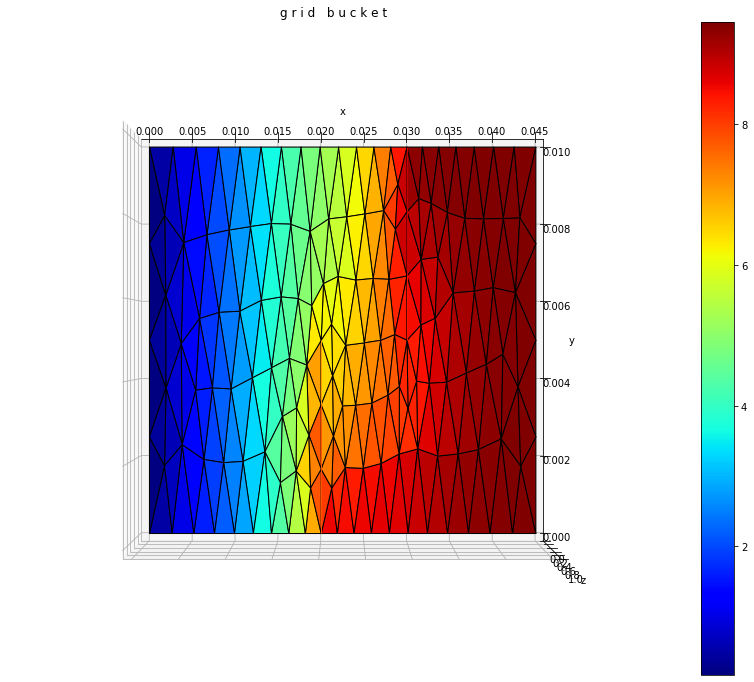

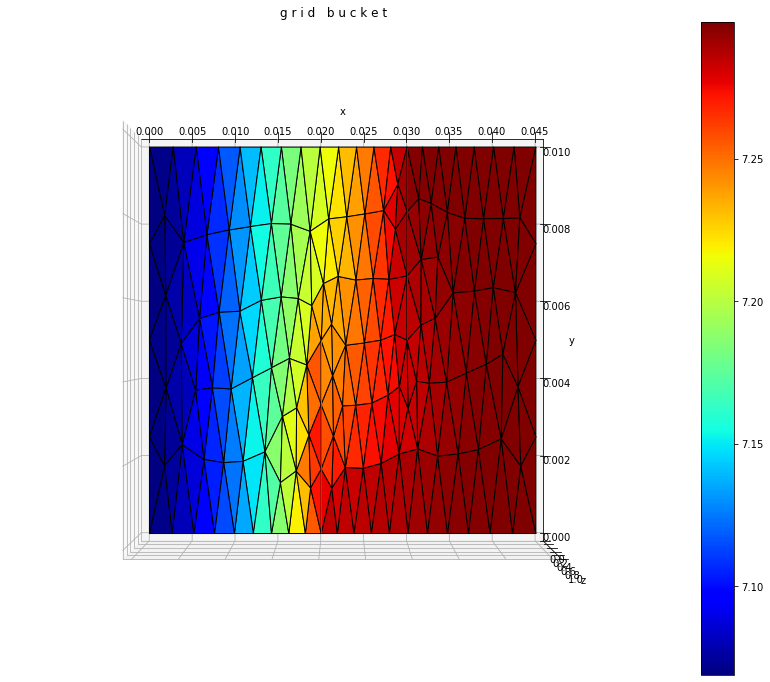

In [20]:

rd=np.zeros(tracer1.size)
#for i in range(10):
#for i in range(n_steps):
for i in range(1,n_steps+1,1):
    rd=reaction.compute_rd(tracer1,rd)
    if np.isclose((i-1) % save_every, 0):
            exporter1.write_vtu(export_field1, time_step=int((i-1) // save_every))
            exporter2.write_vtu(export_field2, time_step=int((i-1) // save_every))
            for g,d in gb:
                print("Ca")
                print(d[pp.STATE]["Ca"])
            for g,d in gb1:
                print("CaSiO3")
                print(d[pp.STATE]["CaSiO3"])
            print("FINE")
            print("rd")
            print(rd)
    
    #rd=reaction.compute_rd(tracer1,rd)
    tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca+rhs_mass_Ca*rd*tracer2*parameter["time_step"])
    tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3-rhs_mass_CaSiO3*rd*tracer2*parameter["time_step"])
    #tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca)
    #tracer2 = IEsolver_CaSiO3(rhs_mass_Ca * tracer2 + rhs_source_adv_CaSiO3)
    
    
    assembler_Ca.distribute_variable(
        tracer1,
        variable_names=[Ca,transport.mortar_variable],
    )
    assembler_CaSiO3.distribute_variable(
        tracer2,
        variable_names=[CaSiO3,transport.mortar_variable],
    )
    #print("tracer1")
    #print(tracer1)
    
exporter1.write_vtu(export_field1, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
    
exporter2.write_vtu(export_field2, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
exporter1.write_pvd(time_steps)
exporter2.write_pvd(time_steps)
transport.plot_tracer(Ca)
transport_CaSiO3.plot_tracer(CaSiO3)